### Load packages

In [10]:
%matplotlib inline

import datacube
from datacube.storage import masking
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr

sys.path.append("../Scripts")
from dea_plotting import display_map
from dea_datahandling import wofs_fuser

### Connect to the datacube

In [11]:
dc = datacube.Datacube(app="Applying_WOfS_bitmasking")

### Analysis parameters

In [12]:
# Define your period of interest
time = ("2010-01-01", "2010-12-31")

In [13]:
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

location = 'Murray Valley'
min_x = 1100000
max_x = 1200000
min_y = -4000000
max_y = -3900000

### View the selected location

In [14]:
# Make sure to change the location for in the save file
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

x = (min_x, max_x)
y = (min_y, max_y)

res_x = 100
res_y = -100

# Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## Load WOFL data


To load WOFL data, we can first create a re-usable query that will define the spatial extent and time period we are interested in, as well as other important parameters that are used to correctly load the data.

As WOFLs are created scene-by-scene, and some scenes overlap, it's important when loading data to `group_by` solar day, and ensure that the data between scenes is combined correctly by using the WOfS `fuse_func`.
This will merge observations taken on the same day, and ensure that important data isn't lost when overlapping datasets are combined.

In [15]:
# Create a reusable query
query = {
    "x": x,
    "y": y,
    "time": time,
    "crs": "EPSG:3577",
    "output_crs": "EPSG:3577",
    "resolution": (-25, 25),
    "group_by": "solar_day",
    "fuse_func": wofs_fuser,
}

In [16]:
# Load the data from the datacube
wofls = dc.load(product="wofs_albers", **query)
wofls

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2
Attributes:
    crs:      EPSG:3577

In [17]:
# Set which time index you will look at
index = 7

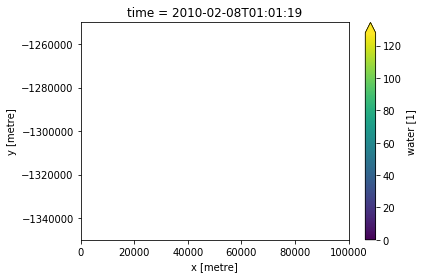

In [18]:
# Plot the loaded WOFLs
wofls.isel(time=index).water.plot(vmin=0,vmax=128)
plt.show()

In [19]:
# Select one image of interest (`time=0` selects the first observation)
wofl = wofls.isel(time=index)

### Understanding the WOFLs

As mentioned above, WOFLs are stored as a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular feature. Below is a breakdown of which bits represent which features, along with the decimal value associated with that bit being set to true.

| Attribute | Bit / position   | Decimal value |
|------|------|----|
| No data | 0:   `0-------` or `1-------` | 1|
| Non contiguous | 1:   `-0------` or `-1------` | 2 |
| Sea | 2:   `--0-----` or `--1-----` | 4 |
| Terrain or low solar angle | 3:   `---0----` or `---1----` | 8 |
| High slope | 4:   `----0---` or `----1---` | 16 |
| Cloud shadow | 5:   `-----0--` or `-----1--` | 32 |
| Cloud | 6:   `------0-` or `------1-` | 64 |
| Water | 7:   `-------0` or `-------1` | 128 |


The values in the above plots are the decimal representation of the combination of set flags. 
For example a value of 136 indicates water (128) AND terrain shadow / low solar angle (8) were observed for the pixel,
whereas a value of 144 would indicate water (128) AND high slope (16).

This flag information is available inside the loaded data and can be visualised as below

In [20]:
# Display details of available flags
flags = masking.describe_variable_flags(wofls)
flags["bits"] = flags["bits"].astype(str)
flags.sort_values(by="bits")

,bits,values,description
nodata,0,"{'0': False, '1': True}",No data
noncontiguous,1,"{'0': False, '1': True}",At least one EO band is missing over over/unde...
sea,2,"{'0': False, '1': True}",Sea
terrain_or_low_angle,3,"{'0': False, '1': True}",terrain shadow or low solar angle
high_slope,4,"{'0': False, '1': True}",High slope
cloud_shadow,5,"{'0': False, '1': True}",Cloud shadow
cloud,6,"{'0': False, '1': True}",Cloudy
dry,"[7, 6, 5, 4, 3, 1, 0]",{'0': True},No water detected
wet,"[7, 6, 5, 4, 3, 1, 0]",{'128': True},Clear and Wet


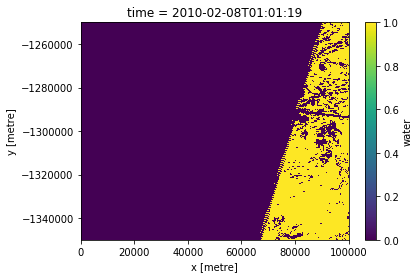

In [21]:
# Show areas flagged as water only (with no other flags set)
wofl = wofls.isel(time=index)
(wofl.water == 0).plot.imshow()
plt.show()

## Masking 
We can convert the WOFL bit field into a binary array containing True and False values. 
This allows us to use the WOFL data as a mask that can be applied to other datasets.

The `make_mask` function allows us to create a mask using the flag labels (e.g. "wet" or "dry") rather than the binary numbers we used above.


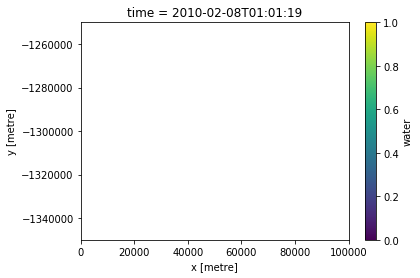

In [22]:
# Create a mask based on all 'wet' pixels
wetwofl = masking.make_mask(wofl, wet=True)
wetwofl.water.plot()
plt.show()

> **NOTE**: As you can see there is a difference between the above two plots. 
The first (where `water == 128`) is looking at pixels where ONLY the water observation flag was set. For coastal areas the 'sea' bit is also flagged. 
The second image (using `wet=True`), also looks at pixels where the water observation flag was set.

### Load something to mask
In the following example, we demonstrate how WOFS can be used as a mask to remove certain features (e.g. water) from another dataset.

We will apply the mask to the 'Fractional Cover' (FC) dataset.
This dataset estimates the percentage of photosythetic vegetation, non-photosythetic vegetation and bare soil within each satellite pixel, but gives inaccurate values in pixels that contain water.
We can use WOFL data to remove these potentially inaccurate pixels from the FC dataset.

In the next cell, we load fractional cover for the same extents as the WOFL data by using the `like` argument.
For more details about this, see the [introduction to loading data](../Beginners_guide/04_Loading_data.ipynb).

In [23]:
# Load a fractional cover (FC) tile to match the WOFLs data by using 'like'
fc = dc.load(product=["ls5_fc_albers","ls7_fc_albers"], group_by="solar_day", like=wofls)


In [24]:
fc

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:      EPSG:3577

In [25]:
fc1 = fc.isel(time=index)

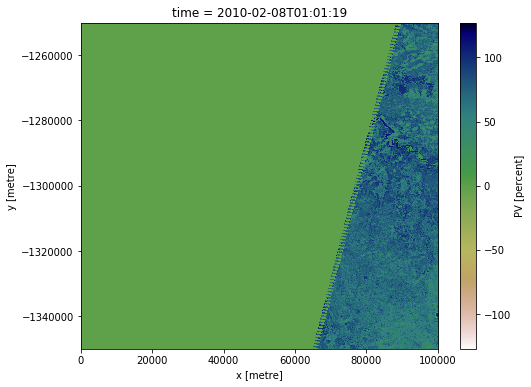

In [26]:
# Visualise the loaded tile
fc1.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))
plt.show()

### Mask water from FC with WOfS

Using the mask created above we can mask water from the FC image

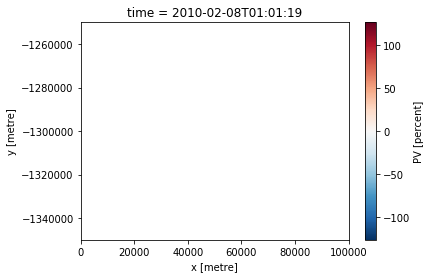

In [27]:
masked = fc1.where(wetwofl.water == False)
masked.PV.plot()
plt.show()

### Mask more things!

Flags can be combined. 
When chaining flags together, they will be combined in a logical AND fashion. 

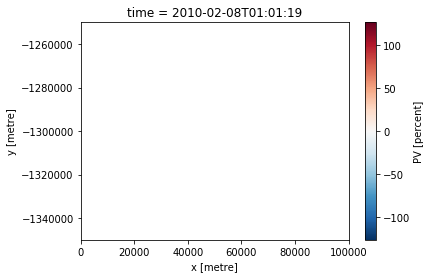

In [28]:
# Removing clouds and their shadows
clear = {"cloud_shadow": False, "cloud": False}

cloudfree = masking.make_mask(wofl, **clear)
cloudfree_fc = fc1.where(cloudfree.water == True)
cloudfree_fc.PV.plot()
plt.show()

Or, to look at only the clear areas which are good quality data and not wet, we can use the 'dry' flag.


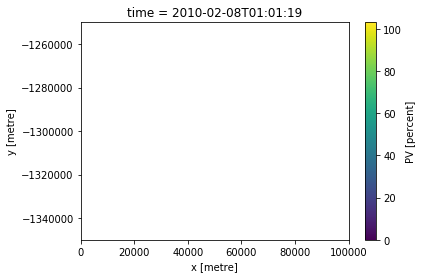

In [29]:
# FC where it's clear and dry
good_data_mask = masking.make_mask(wofl, dry=True)
good_fc = fc1.where(good_data_mask.water == True)
good_fc.PV.plot()
plt.show()

## Gabrielle's struggle town

In [31]:
# Check before merge
fc

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:      EPSG:3577

In [32]:
# Check before merge
wofls

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2
Attributes:
    crs:      EPSG:3577

In [33]:
# Merge the two datasets
merged = xr.merge([fc,wofls])
merged

<xarray.Dataset>
Dimensions:  (time: 61, x: 4000, y: 4000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-06T01:07:59 ... 2010-12-24T01:09:41.500000
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (time, y, x) int16 0 2 0 0 0 2 0 5 0 ... -1 -1 -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 51 53 51 48 58 43 49 61 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 56 50 55 58 48 60 57 40 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 24 24 24 24 24 23 24 25 ... -1 -1 -1 -1 -1 -1 -1
    water    (time, y, x) int16 132 132 132 132 132 132 132 ... 2 2 2 2 2 2 2

In [50]:
# Select an individual time
test = merged.isel(time=7)

# Mask out where unclear pixels
test_masked = test.where(test.water == 1,test)
test_masked

<xarray.Dataset>
Dimensions:  (x: 4000, y: 4000)
Coordinates:
    time     datetime64[ns] 2010-02-08T01:01:19
  * y        (y) float64 -1.25e+06 -1.25e+06 -1.25e+06 ... -1.35e+06 -1.35e+06
  * x        (x) float64 12.5 37.5 62.5 87.5 ... 9.994e+04 9.996e+04 9.999e+04
Data variables:
    BS       (y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 14 11 13 10 12 12 13 9
    PV       (y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 48 48 49 47 39 38 43 48
    NPV      (y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 37 40 37 42 48 49 43 41
    UE       (y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 16 15 16 15 14 14 14 15
    water    (y, x) int16 231 231 231 231 231 231 231 231 ... 0 0 0 0 0 0 0 0

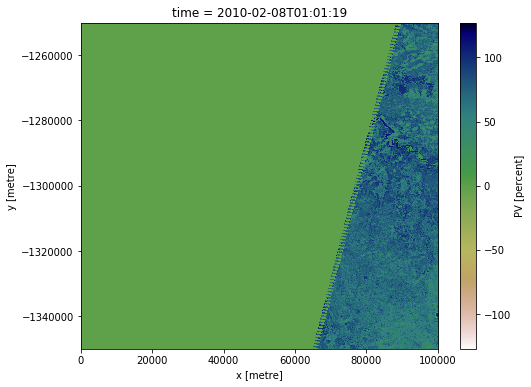

In [51]:
# Visualise the tile before masking
test.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))
plt.show()

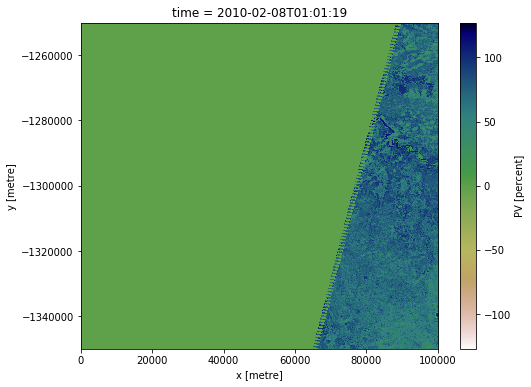

In [52]:
# Visualise the tile before masking
test_masked.PV.plot.imshow(cmap="gist_earth_r", figsize=(8, 6))
plt.show()